In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate

from TO_sim.get_sec_r import get_r_Fun,get_rp,get_rp2,get_rp3,integrand_Rd3
from tqdm.notebook import tqdm
from parfor import parfor

In [ ]:
# 저장된 npz 파일 로드
loaded_data = np.load('Simul/RR.npz', allow_pickle=True)
# 딕셔너리로 변환
RR = dict(loaded_data['RR'].item())  # .item()을 사용해 원래 딕셔너리로 변환

In [104]:
m = 6

In [105]:
Ks = np.arange(0,10.01,0.1)
ms = np.arange(0,10.02,0.1)

In [107]:
RR = {}
RR['u'] = {}
RR['d'] = {}
RR['u']['rp'] = {}
RR['d']['rp'] = {}
RR['u']['rp0'] = {}
RR['d']['rp0'] = {}

RR['u']['R'] = {}
RR['u']['R0'] = {}
RR['u']['SIG'] = {}
RR['u']['OPS'] = {}


In [108]:
for m in tqdm(ms):
# @parfor (ms)
# def get_RR(m):
    F = get_r_Fun(m)
    R_0u = F['u']['R0'](Ks)
    idx = np.isnan(R_0u)
    K_urp = Ks[~idx]
    R_0u = R_0u[~idx]
    OPS = F['u']['OPS'](K_urp)
    _,rp_d,rp_u,rp0_d,rp0_u = get_rp(K_urp,R_0u,OPS,m,MAX=False)
    NN = np.nan* np.zeros_like(idx)[idx]
    RR['d']['rp'][m] = np.r_[NN,rp_d]
    RR['u']['rp'][m] = np.r_[NN,rp_u]
    RR['d']['rp0'][m] = np.r_[NN,rp0_d]
    RR['u']['rp0'][m] = np.r_[NN,rp0_u]
    RR['u']['R'][m] = F['u']['R'](Ks)
    RR['u']['R0'][m] = F['u']['R0'](Ks)
    sigma = 2*rp_d * np.sqrt(1/2  - m*K_urp*R_0u / (4*(4*m**2 * OPS**2 + 1)) - ((m*K_urp*R_0u)/(2*(m**2*OPS**2 + 1)))**2)
    RR['u']['SIG'][m] = np.r_[NN,rp0_u]
    RR['u']['OPS'][m] = np.r_[NN,OPS]


  0%|          | 0/101 [00:00<?, ?it/s]

/Users/kimgug-young/Desktop/데스크탑 - 김국영의 MacBook Pro/KURAMOTO 1st order/Kuramoto-model/TO_sim/get_sec_r.py:103: RuntimeWarning: divide by zero encountered in scalar divide
  a = 1/np.sqrt(X*m)
/Users/kimgug-young/Desktop/데스크탑 - 김국영의 MacBook Pro/KURAMOTO 1st order/Kuramoto-model/TO_sim/get_sec_r.py:104: RuntimeWarning: invalid value encountered in scalar subtract
  b = 4/np.pi * a - 0.3056*a**3
/Users/kimgug-young/Desktop/데스크탑 - 김국영의 MacBook Pro/KURAMOTO 1st order/Kuramoto-model/TO_sim/get_sec_r.py:153: RuntimeWarning: divide by zero encountered in scalar divide
  a = 1/np.sqrt(K*rp*m)
/Users/kimgug-young/Desktop/데스크탑 - 김국영의 MacBook Pro/KURAMOTO 1st order/Kuramoto-model/TO_sim/get_sec_r.py:154: RuntimeWarning: invalid value encountered in scalar subtract
  b = 4/np.pi * a - 0.3056*a**3
/Users/kimgug-young/Desktop/데스크탑 - 김국영의 MacBook Pro/KURAMOTO 1st order/Kuramoto-model/TO_sim/get_sec_r.py:161: IntegrationWarning: The occurrence

KeyboardInterrupt: 

In [ ]:
np.savez('Simul/RR_0.npz',RR=RR,ms=ms,Ks=Ks)

In [24]:
df = pd.DataFrame(RR)

In [7]:
df_A = pd.read_excel(f'NEW Order parameter and secondary cluster NEW.xlsm',index_col=[0,1])
df_A2 = pd.read_excel('Order parameter and secondary cluster with rsecd.xlsm',index_col=[0,1])

In [97]:
N = 5000
df_new = pd.read_excel(f'N = {N} seed = 10 QNORMAL w pv.xlsm',index_col=[0,1])

In [55]:
df

,u,d
rp,"{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,...","{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,..."
rp0,"{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,...","{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,..."
R,"{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,...",NaN
R0,"{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,...",NaN
SIG,"{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,...",NaN
OPS,"{0.0: [nan, nan, nan, nan, nan, nan, nan, nan,...",NaN


In [67]:
RPU = pd.DataFrame(df['u']['rp'],index=Ks).to_numpy(dtype=float)
RPD = pd.DataFrame(df['d']['rp'],index=Ks).to_numpy(dtype=float)
RPU0 = pd.DataFrame(df['u']['rp0'],index=Ks).to_numpy(dtype=float)
RPD0 = pd.DataFrame(df['d']['rp0'],index=Ks).to_numpy(dtype=float)
R0A = pd.DataFrame(df['u']['R0'],index=Ks).to_numpy(dtype=float)
SIG = pd.DataFrame(df['u']['SIG'],index=Ks).to_numpy(dtype=float)

In [68]:
RP2U = pd.DataFrame(df['u']['rp'],index=Ks).to_numpy(dtype=float)
RP2D = pd.DataFrame(df['d']['rp'],index=Ks).to_numpy(dtype=float)
RP2U0 = pd.DataFrame(df['u']['rp0'],index=Ks).to_numpy(dtype=float)
RP2D0 = pd.DataFrame(df['d']['rp0'],index=Ks).to_numpy(dtype=float)

In [98]:
RP = df_new['r+'].unstack().to_numpy(float)
R0 = df_new['r0'].unstack().to_numpy(float)
RM = df_new['r-'].unstack().to_numpy(float)
SIG_S = df_new['sig'].unstack().to_numpy(float)

In [99]:
DRP_AS = (RPU - RP) + (RPU - RM)
R0_SA = (R0 - R0A) 
# np.nanmin(R0P), np.nanmax(R0P)

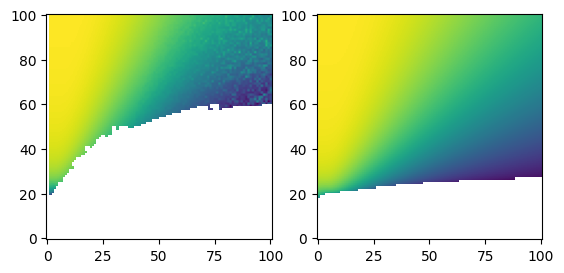

In [100]:
plt.subplot(121)
plt.imshow(R0,origin='lower')
plt.subplot(122)

plt.imshow(R0A,origin='lower')

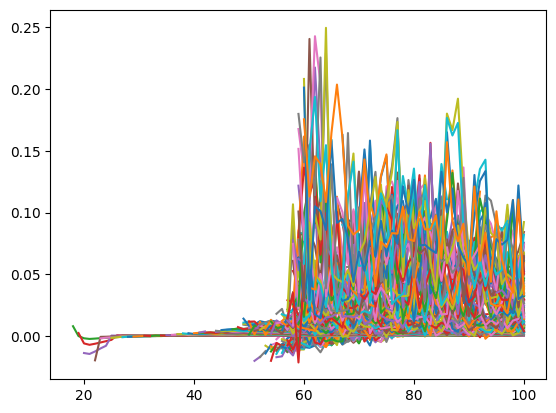

In [101]:
plt.plot(DRP_AS);
plt.plot(R0_SA);

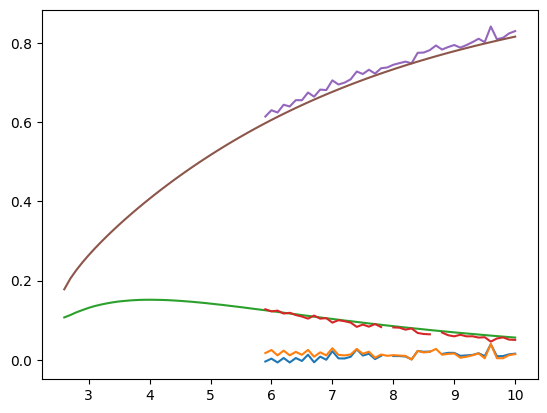

In [102]:
plt.plot(Ks,DRP_AS[:,70])
plt.plot(Ks,R0_SA[:,70])
plt.plot(Ks,RPU[:,70])
plt.plot(Ks,RP[:,70])
plt.plot(Ks,R0[:,70])
plt.plot(Ks,R0A[:,70])

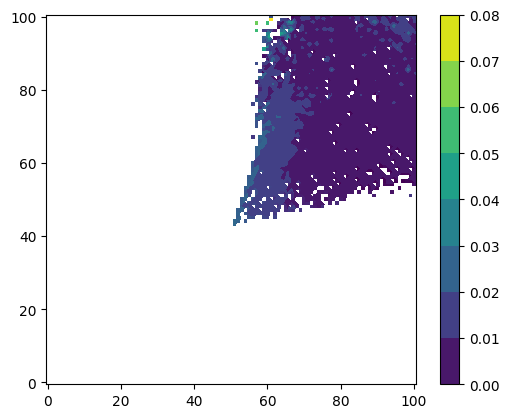

In [103]:
plt.imshow(abs(R0_SA.T - DRP_AS.T),origin='lower')#,vmin=0,vmax=0.3,cmap='tab20c',extent=[Ks.min(), 10, ms.min(),10])
plt.contourf(abs(R0_SA.T - DRP_AS.T),origin='lower')#,vmin=0,vmax=0.3,cmap='tab20c',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar()

In [36]:
A = np.where(SIG_S > 1e-2)

In [ ]:
B = np.where(SIG_S > 5e-3,abs(SIG_S -SIG.T),np.nan)

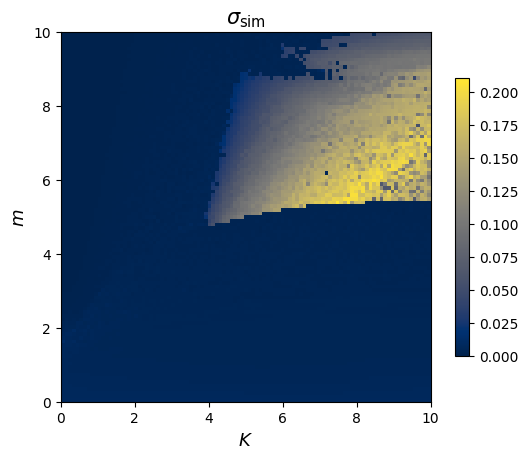

In [66]:
plt.imshow(SIG_S,origin='lower',vmin=0,cmap='cividis',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar(shrink=0.75)
plt.ylabel(r'$m$',fontsize=13)
plt.xlabel(r'$K$',fontsize=13)
plt.title(r'$\sigma_{\rm{sim}}$', fontsize=15)
plt.gca().set_aspect('equal')

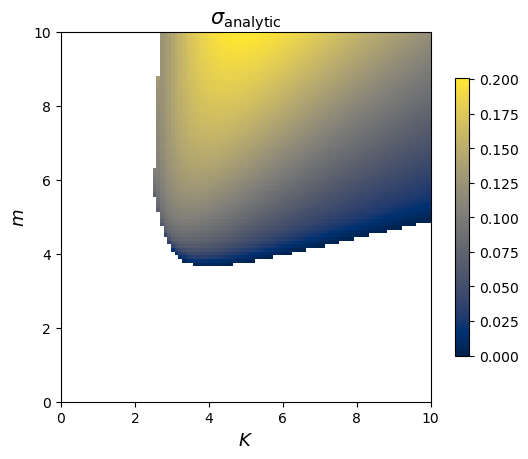

In [92]:
plt.imshow(SIG.T,origin='lower',vmin=0,cmap='cividis',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar(shrink=0.75)
plt.ylabel(r'$m$',fontsize=13)
plt.xlabel(r'$K$',fontsize=13)
plt.title(r'$\sigma_{\rm{analytic}}$', fontsize=15)
plt.gca().set_aspect('equal')

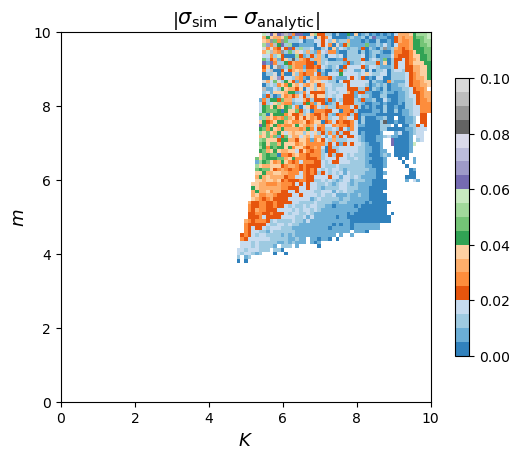

In [87]:
plt.imshow(B,origin='lower',vmin=0,vmax=0.1,cmap='tab20c',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar(shrink=0.75)
plt.ylabel(r'$m$',fontsize=13)
plt.xlabel(r'$K$',fontsize=13)
plt.title(r'$\left|\sigma_{\rm{sim}} - \sigma_{\rm{analytic}}\right|$', fontsize=15)
plt.gca().set_aspect('equal')

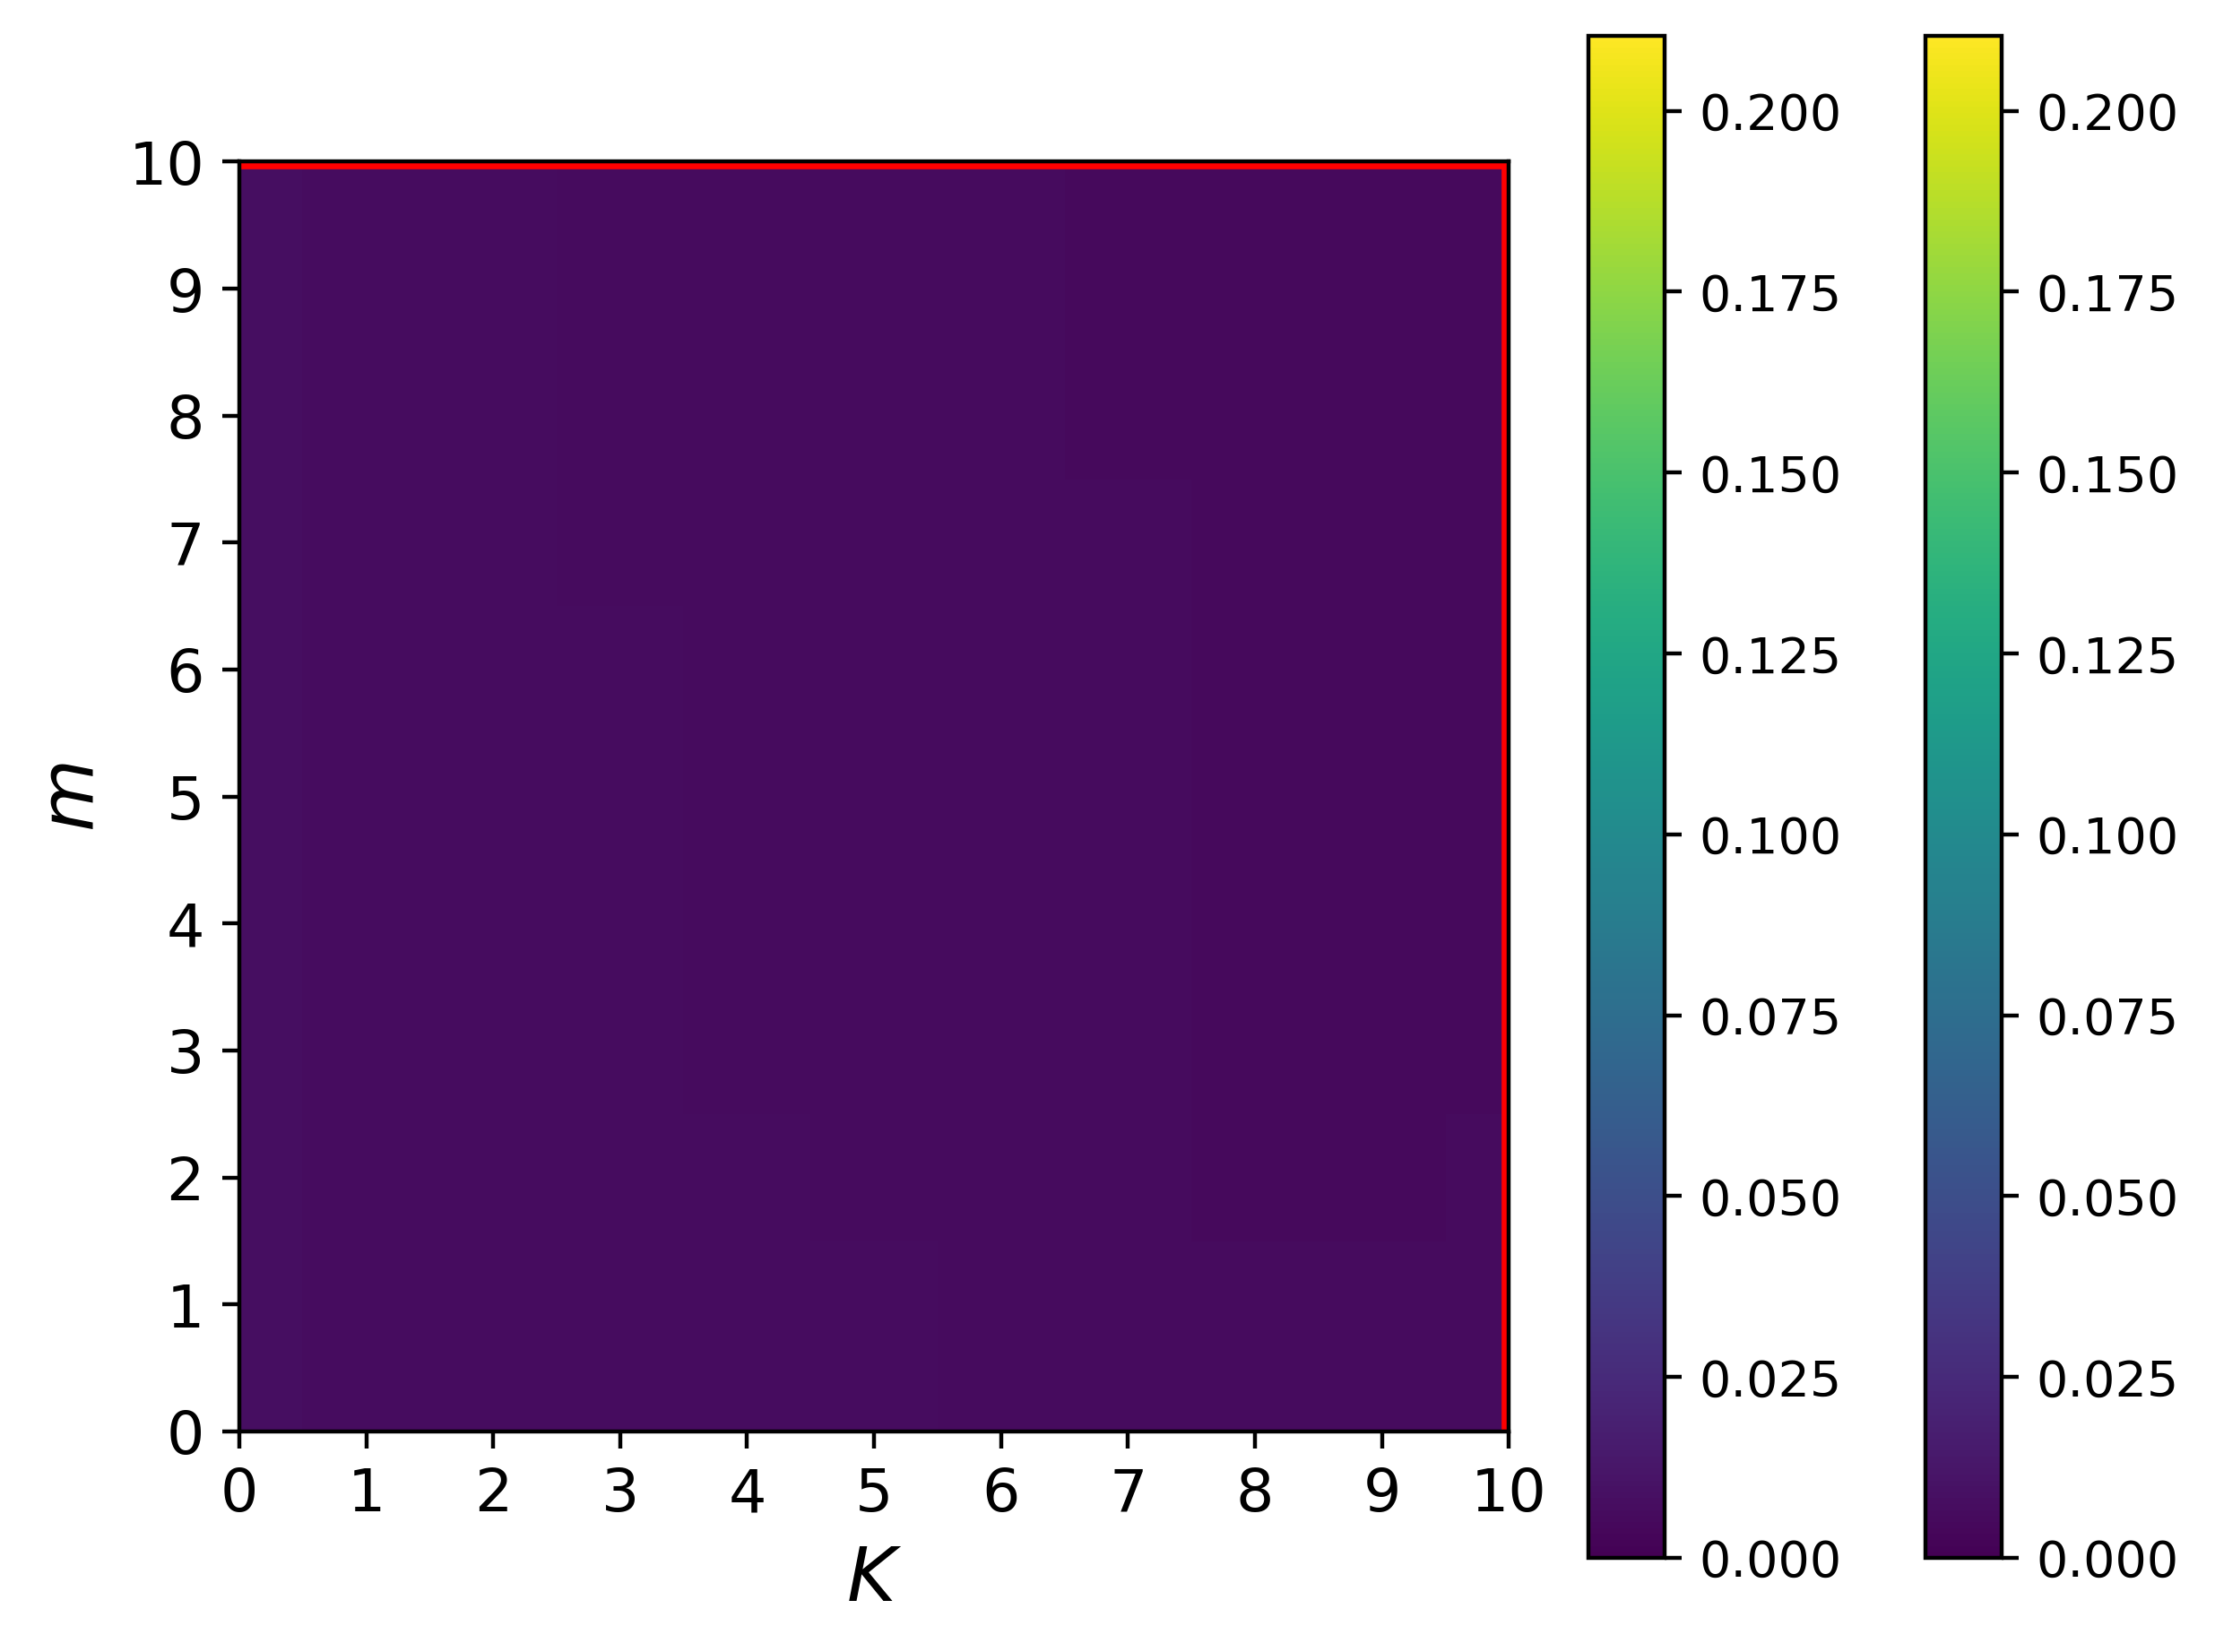

In [51]:
import matplotlib.colors as mcolors
plt.figure(dpi=400)
# imshow를 사용하여 RP2U-RPU의 차이를 시각화
plt.imshow(SIG.T, origin='lower',cmap='Blues', aspect='auto', extent=[Ks.min(), Ks.max(), ms.min(), ms.max()])
plt.imshow(SIG.T, origin='lower',cmap='inferno', aspect='auto', extent=[Ks.min(), Ks.max(), ms.min(), ms.max()],vmax=0.2,vmin=0)

plt.imshow(df_new['sig'].unstack().to_numpy(float).T,origin='lower')
plt.colorbar()
# plt.grid()
plt.colorbar()

# x축과 y축의 tick 설정
plt.xticks(np.linspace(Ks.min(), 10, num=11))
plt.yticks(np.linspace(0, 10, num=11))

# contour 라인을 여러 개 그리기
# contour_levels = np.logspace(-3, 0, 10)  # 원하는 contour 레벨 설정
# contour_colors = ['white', 'red', 'blue', 'green', 'yellow', 'cyan', 'magenta', 'black', 'orange', 'purple']
# im = plt.contour(Ks, ms, (RP2U - RPU).T, levels=contour_levels, colors=contour_colors)

# colorbar 추가
# plt.clabel(im, inline=True, fontsize=10, colors='black')
plt.hlines(10,0,10,color='red',lw=3)
plt.vlines(10,0,10,color='red',lw=3)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$m$',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [24]:
m = 10
F = get_r_Fun(m)
R_0u = F['u']['R0'](Ks)
idx = np.isnan(R_0u)
K_urp = Ks[~idx]
R_0u = R_0u[~idx]
OPS = F['u']['OPS'](K_urp)
Ks_,rp_d,rp,rp0_d,rp0_u = get_rp(K_urp,R_0u,OPS,m,MAX=False)
Ks_,rp2_d,rp2,rp20_d,rp20_u = get_rp2(K_urp,R_0u,OPS,m,MAX=False)
Ks_,rp2_d,rp3,rp20_d,rp20_u = get_rp3(K_urp,R_0u,OPS,m,MAX=False)

F_Krp = interpolate.interp1d(Ks_,rp2,bounds_error=False)
F_Krp3 = interpolate.interp1d(Ks_,rp3,bounds_error=False)

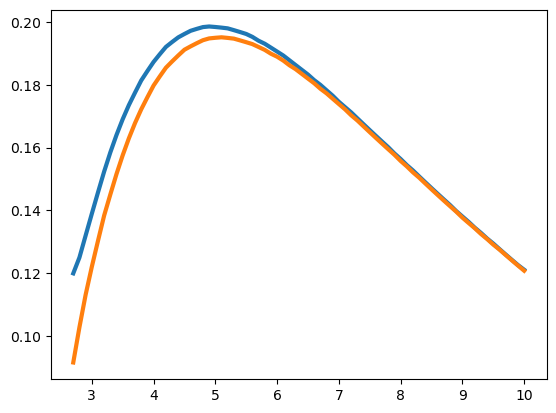

In [21]:
plt.plot(Ks_,rp2,label=r'before',lw=3)
plt.plot(Ks_,rp,label=r'before',lw=3)



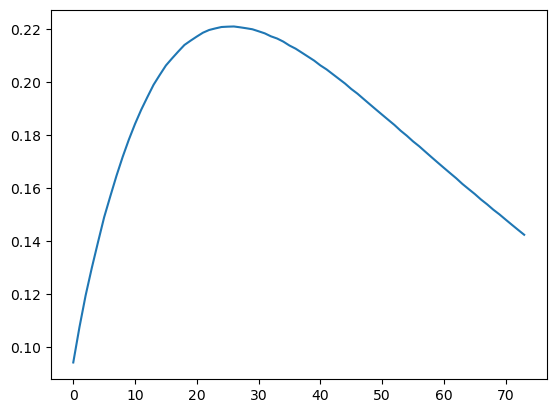

In [28]:
plt.plot(sigma)